# IPO 180-Day Index vs S&P 500 — Online Portfolio Optimizer (OGD)

This notebook builds a **custom market-cap weighted IPO index** where each IPO stock:
- Enters the index on its IPO date
- Exits the index after **180 trading days**
- Is **weighted by market capitalization** (larger IPOs have more weight)

We then run an Online Gradient Descent (OGD) portfolio optimizer to dynamically allocate between:
1. **S&P 500** (via SPY)
2. **IPO 180-Day Index** (market-cap weighted basket of recent IPOs)

Time horizon: **2020-2026**

In [1]:
# Core imports
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

torch.set_default_dtype(torch.float32)
np.random.seed(42)
torch.manual_seed(42)

print("Imports complete.")

Imports complete.


In [2]:
# Install yfinance if needed
try:
    import yfinance as yf
    print(f"yfinance version: {yf.__version__}")
except ImportError:
    !pip install yfinance
    import yfinance as yf

yfinance version: 1.1.0


## 1) IPO Data Collection

We'll use a curated list of significant IPOs from 2020-2025. This includes major tech IPOs, SPACs that completed mergers, and other notable public offerings.

In [3]:
# Comprehensive list of IPOs from 2020-2025 with their IPO dates
# Format: (ticker, ipo_date)
# Sources: NYSE, NASDAQ IPO calendars, SEC filings

IPO_LIST = [
    # 2020 IPOs - Major
    ("SNOW", "2020-09-16"),    # Snowflake
    ("ABNB", "2020-12-10"),    # Airbnb
    ("DASH", "2020-12-09"),    # DoorDash
    ("PLTR", "2020-09-30"),    # Palantir
    ("U", "2020-09-18"),       # Unity Software
    ("AI", "2020-12-09"),      # C3.ai
    ("WISH", "2020-12-16"),    # ContextLogic
    ("ROOT", "2020-10-28"),    # Root Insurance
    ("LMND", "2020-07-02"),    # Lemonade
    ("BIGC", "2020-08-05"),    # BigCommerce
    ("NCNO", "2020-07-14"),    # nCino
    ("DKNG", "2020-04-24"),    # DraftKings
    ("NKLA", "2020-06-04"),    # Nikola
    ("VROOM", "2020-06-09"),   # Vroom
    ("SUMO", "2020-09-17"),    # Sumo Logic
    ("JAMF", "2020-07-22"),    # Jamf Holdings
    ("ASAN", "2020-09-30"),    # Asana
    ("MCFE", "2020-10-22"),    # McAfee
    ("AMWL", "2020-09-17"),    # American Well
    ("FROG", "2020-09-16"),    # JFrog
    ("GAN", "2020-05-05"),     # GAN Limited
    ("POSH", "2021-01-14"),    # Poshmark
    
    # 2021 IPOs - Major
    ("RBLX", "2021-03-10"),    # Roblox
    ("COIN", "2021-04-14"),    # Coinbase
    ("HOOD", "2021-07-29"),    # Robinhood
    ("RIVN", "2021-11-10"),    # Rivian
    ("LCID", "2021-07-26"),    # Lucid Motors
    ("SOFI", "2021-06-01"),    # SoFi Technologies
    ("PATH", "2021-04-21"),    # UiPath
    ("CPNG", "2021-03-11"),    # Coupang
    ("OSCR", "2021-03-03"),    # Oscar Health
    ("BMBL", "2021-02-11"),    # Bumble
    ("AFRM", "2021-01-13"),    # Affirm
    ("DUOL", "2021-07-28"),    # Duolingo
    ("DOCS", "2021-08-05"),    # Doximity
    ("GLBE", "2021-05-13"),    # Global-e Online
    ("RELY", "2021-07-22"),    # Remitly
    ("BROS", "2021-09-15"),    # Dutch Bros
    ("TASK", "2021-06-11"),    # TaskUs
    ("YOU", "2021-05-05"),     # Clear Secure
    ("FIGS", "2021-05-27"),    # FIGS
    ("MNDY", "2021-06-10"),    # Monday.com
    ("TOST", "2021-09-22"),    # Toast
    ("COUR", "2021-03-31"),    # Coursera
    ("BRZE", "2021-11-17"),    # Braze
    ("BIRD", "2021-11-04"),    # Allbirds
    ("RENT", "2021-10-27"),    # Rent the Runway
    ("ONON", "2021-09-15"),    # On Holding
    ("GENI", "2021-04-26"),    # Genius Sports
    ("XPEV", "2020-08-27"),    # XPeng
    ("LI", "2020-07-30"),      # Li Auto
    ("DIDI", "2021-06-30"),    # DiDi (delisted but had IPO)
    ("GRAB", "2021-12-02"),    # Grab Holdings
    ("SE", "2017-10-20"),      # Sea Limited (earlier, warmup)
    ("PLBY", "2021-02-11"),    # PLBY Group
    ("OPEN", "2020-12-21"),    # Opendoor
    ("PAYO", "2021-06-25"),    # Payoneer
    ("VZIO", "2021-03-25"),    # VIZIO
    ("SKIN", "2021-01-22"),    # Beauty Health
    ("JOBY", "2021-08-11"),    # Joby Aviation
    ("NUVB", "2021-02-05"),    # Nuvation Bio
    ("MTTR", "2021-07-23"),    # Matterport
    ("SES", "2022-02-04"),     # SES AI
    ("DNA", "2021-09-17"),     # Ginkgo Bioworks
    ("IONQ", "2021-10-01"),    # IonQ
    ("SRAD", "2021-06-09"),    # Sportradar
    ("PSFE", "2021-03-30"),    # Paysafe
    
    # 2022 IPOs (limited market)
    ("TPG", "2022-01-13"),     # TPG Inc
    ("VTYX", "2022-01-14"),    # Ventyx Biosciences
    ("HLAH", "2022-03-03"),    # Hamilton Lane Alliance
    
    # 2023 IPOs
    ("ARM", "2023-09-14"),     # ARM Holdings
    ("KVYO", "2023-09-20"),    # Klaviyo
    ("CART", "2023-09-19"),    # Instacart/Maplebear
    ("BIRK", "2023-10-11"),    # Birkenstock
    ("CAVA", "2023-06-15"),    # Cava Group
    ("SKWD", "2023-01-13"),    # Skyward Specialty
    ("TXO", "2023-01-27"),     # TXO Partners
    ("GNLX", "2023-01-26"),    # Genelux
    ("IBRX", "2023-10-06"),    # ImmunityBio
    ("KNTE", "2021-02-04"),    # Kinnate Biopharma
    
    # 2024 IPOs
    ("RDDT", "2024-03-21"),    # Reddit
    ("ASPI", "2024-03-28"),    # ASP Isotopes
    ("VKTX", "2020-06-12"),    # Viking Therapeutics
    ("LOAR", "2024-04-26"),    # Loar Holdings
    ("KARO", "2024-03-14"),    # Karooooo
]

# Convert to DataFrame
ipo_df = pd.DataFrame(IPO_LIST, columns=['ticker', 'ipo_date'])
ipo_df['ipo_date'] = pd.to_datetime(ipo_df['ipo_date'])
ipo_df = ipo_df.drop_duplicates(subset='ticker').reset_index(drop=True)

# Sort by IPO date
ipo_df = ipo_df.sort_values('ipo_date').reset_index(drop=True)

print(f"Total unique IPO tickers: {len(ipo_df)}")
print(f"\nIPOs by year:")
ipo_df['year'] = ipo_df['ipo_date'].dt.year
print(ipo_df.groupby('year').size())
print(f"\n")
ipo_df.head(15)

Total unique IPO tickers: 85

IPOs by year:
year
2017     1
2020    25
2021    42
2022     4
2023     9
2024     4
dtype: int64




,ticker,ipo_date,year
0,SE,2017-10-20,2017
1,DKNG,2020-04-24,2020
2,GAN,2020-05-05,2020
3,NKLA,2020-06-04,2020
4,VROOM,2020-06-09,2020
5,VKTX,2020-06-12,2020
6,LMND,2020-07-02,2020
7,NCNO,2020-07-14,2020
8,JAMF,2020-07-22,2020
9,LI,2020-07-30,2020


## 2) Fetch Price Data for All IPO Tickers and SPY

In [4]:
def fetch_price_and_shares_data(tickers, start_date, end_date):
    """
    Fetch adjusted close prices and shares outstanding for a list of tickers.
    Returns two DataFrames: prices and shares_outstanding
    """
    import yfinance as yf
    
    price_data = {}
    shares_data = {}
    failed_tickers = []
    
    for ticker in tickers:
        try:
            stock = yf.Ticker(ticker)
            
            # Get historical prices
            hist = stock.history(start=start_date, end=end_date, auto_adjust=True)
            if not hist.empty and len(hist) > 10:
                price_data[ticker] = hist['Close']
                
                # Get shares outstanding (use current as approximation)
                info = stock.info
                shares = info.get('sharesOutstanding', info.get('impliedSharesOutstanding', None))
                if shares:
                    shares_data[ticker] = shares
                else:
                    # Fallback: estimate from market cap / price
                    mkt_cap = info.get('marketCap', None)
                    if mkt_cap and len(hist) > 0:
                        recent_price = hist['Close'].iloc[-1]
                        if recent_price > 0:
                            shares_data[ticker] = mkt_cap / recent_price
            else:
                failed_tickers.append(ticker)
        except Exception as e:
            failed_tickers.append(ticker)
    
    if failed_tickers:
        print(f"Failed to fetch data for: {failed_tickers}")
    
    prices = pd.DataFrame(price_data)
    
    # Remove timezone info from index for compatibility
    if prices.index.tz is not None:
        prices.index = prices.index.tz_localize(None)
    
    return prices, shares_data

# Define date range
START_DATE = "2020-01-01"
END_DATE = "2026-02-05"

# Get all IPO tickers plus SPY
all_tickers = ipo_df['ticker'].tolist() + ['SPY']

print(f"Fetching price data and shares outstanding for {len(all_tickers)} tickers...")
print("This may take a few minutes...")
prices, shares_outstanding = fetch_price_and_shares_data(all_tickers, START_DATE, END_DATE)

print(f"\nPrice data shape: {prices.shape}")
print(f"Tickers with shares data: {len(shares_outstanding)}")
print(f"Date range: {prices.index.min()} to {prices.index.max()}")

# Show shares outstanding for some tickers
print("\nSample shares outstanding (in millions):")
for ticker in list(shares_outstanding.keys())[:10]:
    print(f"  {ticker}: {shares_outstanding[ticker]/1e6:.1f}M shares")
    
prices.head()

Fetching price data and shares outstanding for 86 tickers...
This may take a few minutes...


$GAN: possibly delisted; no timezone found


$NKLA: possibly delisted; no price data found  (1d 2020-01-01 -> 2026-02-05) (Yahoo error = "No data found, symbol may be delisted")


HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: VROOM"}}}


$VROOM: possibly delisted; no timezone found


$BIGC: possibly delisted; no timezone found


$SUMO: possibly delisted; no timezone found


$MCFE: possibly delisted; no timezone found


$WISH: possibly delisted; no timezone found


$POSH: possibly delisted; no timezone found


$KNTE: possibly delisted; no timezone found


$VZIO: possibly delisted; no timezone found


$DIDI: possibly delisted; no timezone found


$MTTR: possibly delisted; no timezone found


$HLAH: possibly delisted; no timezone found


Failed to fetch data for: ['GAN', 'NKLA', 'VROOM', 'BIGC', 'SUMO', 'MCFE', 'WISH', 'POSH', 'KNTE', 'VZIO', 'DIDI', 'MTTR', 'HLAH']

Price data shape: (1531, 73)
Tickers with shares data: 73
Date range: 2020-01-02 00:00:00 to 2026-02-04 00:00:00

Sample shares outstanding (in millions):
  SE: 546.5M shares
  DKNG: 497.8M shares
  VKTX: 113.0M shares
  LMND: 74.7M shares
  NCNO: 114.7M shares
  JAMF: 134.1M shares
  LI: 835.4M shares
  XPEV: 779.6M shares
  SNOW: 342.2M shares
  FROG: 118.3M shares


,SE,DKNG,VKTX,LMND,NCNO,JAMF,LI,XPEV,SNOW,FROG,...,ARM,CART,KVYO,IBRX,BIRK,KARO,RDDT,ASPI,LOAR,SPY
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,40.040001,10.68,7.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.96,NaN,NaN,NaN,NaN,NaN,297.699066
2020-01-03,40.490002,10.68,7.77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.04,NaN,NaN,NaN,NaN,NaN,295.444733
2020-01-06,40.480000,10.80,7.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.81,NaN,NaN,NaN,NaN,NaN,296.571930
2020-01-07,41.009998,10.90,7.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.49,NaN,NaN,NaN,NaN,NaN,295.737946
2020-01-08,40.160000,11.26,7.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.70,NaN,NaN,NaN,NaN,NaN,297.314178


In [5]:
# Calculate daily returns
returns = prices.pct_change().dropna(how='all')
print(f"Returns shape: {returns.shape}")
returns.head()

Returns shape: (1530, 73)


,SE,DKNG,VKTX,LMND,NCNO,JAMF,LI,XPEV,SNOW,FROG,...,ARM,CART,KVYO,IBRX,BIRK,KARO,RDDT,ASPI,LOAR,SPY
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-03,0.011239,0.000000,-0.022641,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.020202,NaN,NaN,NaN,NaN,NaN,-0.007573
2020-01-06,-0.000247,0.011236,-0.006435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.056931,NaN,NaN,NaN,NaN,NaN,0.003815
2020-01-07,0.013093,0.009259,-0.016839,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.083989,NaN,NaN,NaN,NaN,NaN,-0.002812
2020-01-08,-0.020727,0.033028,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.060172,NaN,NaN,NaN,NaN,NaN,0.005330
2020-01-09,0.009213,0.087922,0.017128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.059459,NaN,NaN,NaN,NaN,NaN,0.006780


## 3) Build 180-Day Rolling IPO Index (Market-Cap Weighted)

For each trading day, the IPO index includes:
- All stocks that had their IPO within the last 180 trading days
- **Market-cap weighted** basket (larger companies = higher weight)
- Stocks automatically exit after 180 days

In [6]:
def build_180day_ipo_index_mcap(prices_df, ipo_dates_df, shares_dict, holding_days=180, min_names=1):
    """
    Build a MARKET-CAP WEIGHTED IPO index where each stock stays for exactly
    `holding_days` trading days after its IPO.
    
    Parameters:
    -----------
    prices_df : DataFrame with Date index and ticker columns (closing prices)
    ipo_dates_df : DataFrame with 'ticker' and 'ipo_date' columns
    shares_dict : Dict mapping ticker -> shares outstanding
    holding_days : Number of trading days to hold each IPO stock (default 180)
    min_names : Minimum stocks required to compute index return
    
    Returns:
    --------
    ipo_index : DataFrame with columns:
        - ipo_ret: Daily return of the IPO index (market-cap weighted)
        - num_stocks: Number of stocks in the index that day
        - total_market_cap: Total market cap of index constituents
        - constituents: List of tickers in the index
    """
    # Create IPO date lookup
    ipo_lookup = dict(zip(ipo_dates_df['ticker'], ipo_dates_df['ipo_date']))
    
    # Calculate returns
    returns_df = prices_df.pct_change()
    
    # Get trading days for each ticker
    trading_days = {}
    for ticker in prices_df.columns:
        if ticker == 'SPY' or ticker not in ipo_lookup:
            continue
        # Get valid trading days for this ticker (non-NaN prices)
        valid_days = prices_df[ticker].dropna().index.tolist()
        trading_days[ticker] = valid_days
    
    # For each date, determine which IPO stocks are in the index
    all_dates = prices_df.index.tolist()
    
    index_data = []
    
    for date in all_dates:
        eligible_tickers = []
        market_caps = {}
        
        for ticker, ipo_date in ipo_lookup.items():
            if ticker not in trading_days:
                continue
            if ticker not in shares_dict:
                continue
                
            ticker_days = trading_days[ticker]
            
            # Find the first trading day at or after IPO date
            first_trade_idx = None
            for i, d in enumerate(ticker_days):
                if d >= ipo_date:
                    first_trade_idx = i
                    break
            
            if first_trade_idx is None:
                continue
            
            # Check if current date is within the holding period
            if date in ticker_days:
                current_idx = ticker_days.index(date)
                days_since_ipo = current_idx - first_trade_idx
                
                if 0 <= days_since_ipo < holding_days:
                    # Get current price and calculate market cap
                    try:
                        current_price = prices_df.loc[date, ticker]
                        if pd.notna(current_price) and current_price > 0:
                            mcap = current_price * shares_dict[ticker]
                            eligible_tickers.append(ticker)
                            market_caps[ticker] = mcap
                    except:
                        pass
        
        # Calculate market-cap weighted return
        if len(eligible_tickers) >= min_names and len(market_caps) >= min_names:
            total_mcap = sum(market_caps.values())
            
            if total_mcap > 0:
                weighted_return = 0.0
                valid_count = 0
                
                for ticker in eligible_tickers:
                    if ticker in market_caps:
                        try:
                            ret = returns_df.loc[date, ticker]
                            if pd.notna(ret):
                                weight = market_caps[ticker] / total_mcap
                                weighted_return += weight * ret
                                valid_count += 1
                        except:
                            pass
                
                if valid_count >= min_names:
                    ipo_ret = weighted_return
                else:
                    ipo_ret = np.nan
            else:
                ipo_ret = np.nan
        else:
            ipo_ret = np.nan
            total_mcap = 0
        
        index_data.append({
            'date': date,
            'ipo_ret': ipo_ret,
            'num_stocks': len(eligible_tickers),
            'total_market_cap': sum(market_caps.values()) if market_caps else 0,
            'constituents': eligible_tickers
        })
    
    index_df = pd.DataFrame(index_data)
    index_df.set_index('date', inplace=True)
    
    return index_df

print("Building 180-day market-cap weighted IPO index...")
ipo_index = build_180day_ipo_index_mcap(prices, ipo_df, shares_outstanding, holding_days=180, min_names=1)

print(f"\nIPO index shape: {ipo_index.shape}")
print(f"Days with valid returns: {ipo_index['ipo_ret'].notna().sum()}")
print(f"Average number of stocks in index: {ipo_index['num_stocks'].mean():.1f}")
print(f"Average total market cap: ${ipo_index['total_market_cap'].mean()/1e9:.1f}B")
ipo_index.head(20)

Building 180-day market-cap weighted IPO index...



IPO index shape: (1531, 4)
Days with valid returns: 1208
Average number of stocks in index: 8.5
Average total market cap: $150.8B


,ipo_ret,num_stocks,total_market_cap,constituents
date,,,,
2020-01-02,NaN,1,2.188155e+10,[SE]
2020-01-03,0.011239,1,2.212747e+10,[SE]
2020-01-06,-0.000247,1,2.212200e+10,[SE]
2020-01-07,0.013093,1,2.241164e+10,[SE]
2020-01-08,-0.020727,1,2.194712e+10,[SE]
2020-01-09,0.009213,1,2.214933e+10,[SE]
2020-01-10,-0.023439,1,2.163016e+10,[SE]
2020-01-13,0.011117,1,2.187062e+10,[SE]
2020-01-14,-0.001999,1,2.182690e+10,[SE]


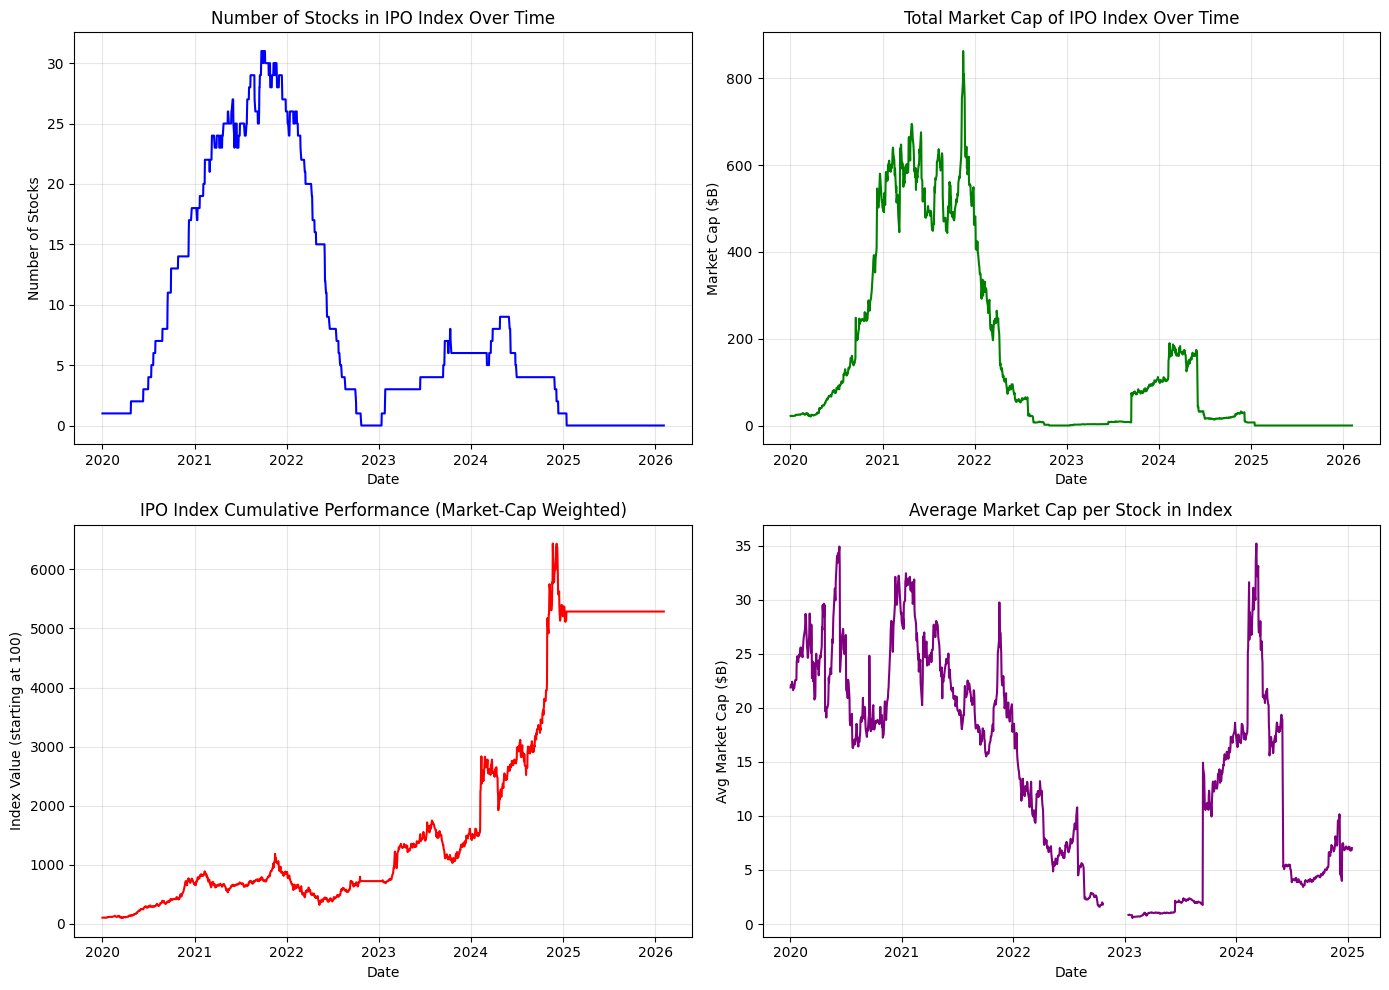

In [7]:
# Show index composition and market cap over time
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Number of stocks
ax1 = axes[0, 0]
ax1.plot(ipo_index.index, ipo_index['num_stocks'], color='blue')
ax1.set_title('Number of Stocks in IPO Index Over Time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Stocks')
ax1.grid(True, alpha=0.3)

# Total market cap
ax2 = axes[0, 1]
mcap_billions = ipo_index['total_market_cap'] / 1e9
ax2.plot(ipo_index.index, mcap_billions, color='green')
ax2.set_title('Total Market Cap of IPO Index Over Time')
ax2.set_xlabel('Date')
ax2.set_ylabel('Market Cap ($B)')
ax2.grid(True, alpha=0.3)

# Cumulative performance
ax3 = axes[1, 0]
cumulative = (1 + ipo_index['ipo_ret'].fillna(0)).cumprod() * 100
ax3.plot(ipo_index.index, cumulative, color='red')
ax3.set_title('IPO Index Cumulative Performance (Market-Cap Weighted)')
ax3.set_xlabel('Date')
ax3.set_ylabel('Index Value (starting at 100)')
ax3.grid(True, alpha=0.3)

# Average market cap per stock
ax4 = axes[1, 1]
avg_mcap = ipo_index['total_market_cap'] / ipo_index['num_stocks'].replace(0, np.nan) / 1e9
ax4.plot(ipo_index.index, avg_mcap, color='purple')
ax4.set_title('Average Market Cap per Stock in Index')
ax4.set_xlabel('Date')
ax4.set_ylabel('Avg Market Cap ($B)')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Sample date: 2022-07-13
Number of constituents: 8

Constituent weights (market-cap based):
  RIVN  : 61.64% ($37.6B)
  GRAB  : 16.26% ($9.9B)
  BRZE  :  7.85% ($4.8B)
  TPG   :  5.14% ($3.1B)
  RENT  :  3.89% ($2.4B)
  SES   :  2.43% ($1.5B)
  VTYX  :  1.86% ($1.1B)
  BIRD  :  0.93% ($0.6B)


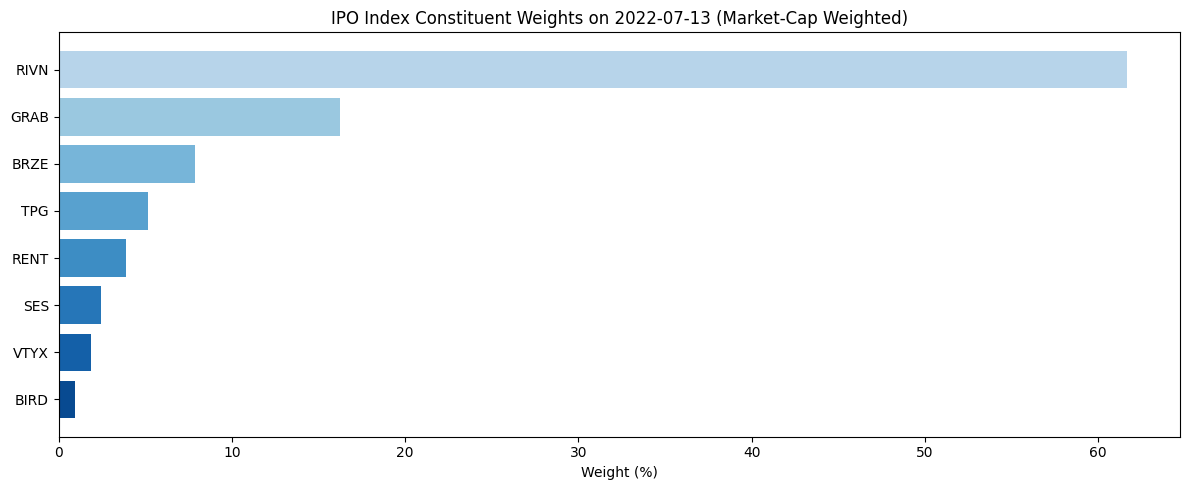

In [8]:
# Show sample constituent weights to demonstrate market cap weighting
# Pick a date with multiple constituents

sample_dates = ipo_index[ipo_index['num_stocks'] >= 3].index

if len(sample_dates) > 0:
    # Pick a date in the middle of the dataset
    sample_date = sample_dates[len(sample_dates) // 2]
    constituents = ipo_index.loc[sample_date, 'constituents']
    
    if constituents:
        print(f"Sample date: {sample_date.strftime('%Y-%m-%d')}")
        print(f"Number of constituents: {len(constituents)}")
        print(f"\nConstituent weights (market-cap based):")
        
        # Calculate weights for this date
        mcaps = {}
        for ticker in constituents:
            if ticker in prices.columns and ticker in shares_outstanding:
                try:
                    price = prices.loc[sample_date, ticker]
                    if pd.notna(price):
                        mcaps[ticker] = price * shares_outstanding[ticker]
                except:
                    pass
        
        total_mcap = sum(mcaps.values())
        weights = {t: mc/total_mcap for t, mc in mcaps.items()}
        
        # Sort by weight
        sorted_weights = sorted(weights.items(), key=lambda x: x[1], reverse=True)
        
        for ticker, weight in sorted_weights:
            mcap_b = mcaps[ticker] / 1e9
            print(f"  {ticker:6s}: {weight:6.2%} (${mcap_b:.1f}B)")
        
        # Visualize
        plt.figure(figsize=(12, 5))
        tickers = [t for t, w in sorted_weights]
        wts = [w for t, w in sorted_weights]
        colors = plt.cm.Blues(np.linspace(0.3, 0.9, len(tickers)))
        plt.barh(tickers[::-1], [w*100 for w in wts[::-1]], color=colors[::-1])
        plt.xlabel('Weight (%)')
        plt.title(f'IPO Index Constituent Weights on {sample_date.strftime("%Y-%m-%d")} (Market-Cap Weighted)')
        plt.tight_layout()
        plt.show()
else:
    print("No dates with multiple constituents found.")

## 4) Combine SPY and IPO Index Returns

In [9]:
# Get SPY returns
spy_ret = returns['SPY'].rename('SPY')

# Combine with IPO index returns
combined_rets = pd.DataFrame({
    'SPY': spy_ret,
    'IPO_INDEX': ipo_index['ipo_ret']
})

# Drop rows where either is missing
combined_rets = combined_rets.dropna()

print(f"Combined returns shape: {combined_rets.shape}")
print(f"Date range: {combined_rets.index.min()} to {combined_rets.index.max()}")
print(f"\nSummary statistics:")
print(combined_rets.describe())

Combined returns shape: (1208, 2)
Date range: 2020-01-03 00:00:00 to 2025-01-14 00:00:00

Summary statistics:
               SPY    IPO_INDEX
count  1208.000000  1208.000000
mean      0.000577     0.004016
std       0.013166     0.038760
min      -0.109424    -0.163062
25%      -0.004980    -0.017093
50%       0.000963     0.001834
75%       0.007140     0.023271
max       0.090603     0.392164


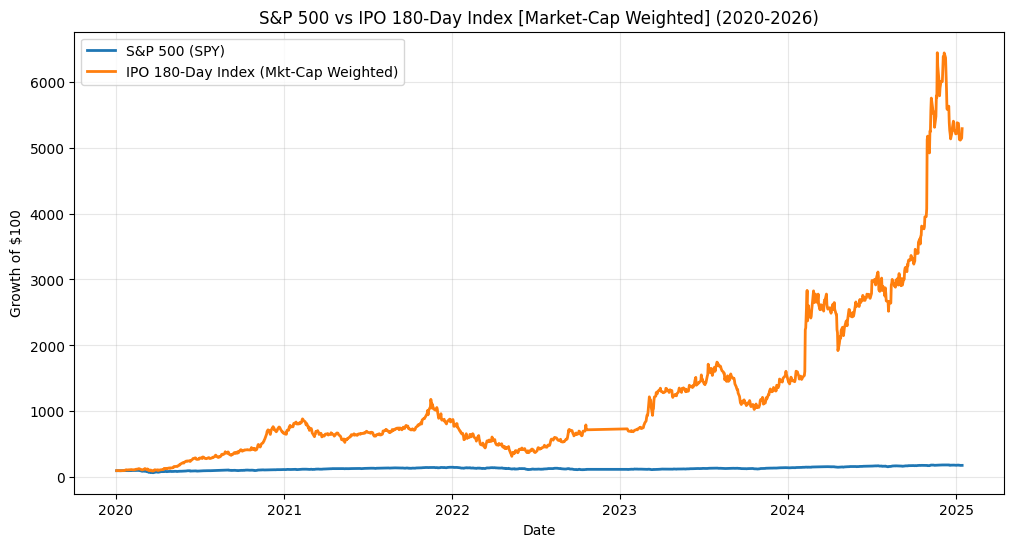

In [10]:
# Plot cumulative returns comparison
cum_rets = (1 + combined_rets).cumprod() * 100

plt.figure(figsize=(12, 6))
plt.plot(cum_rets.index, cum_rets['SPY'], label='S&P 500 (SPY)', linewidth=2)
plt.plot(cum_rets.index, cum_rets['IPO_INDEX'], label='IPO 180-Day Index (Mkt-Cap Weighted)', linewidth=2)
plt.legend()
plt.title('S&P 500 vs IPO 180-Day Index [Market-Cap Weighted] (2020-2026)')
plt.xlabel('Date')
plt.ylabel('Growth of $100')
plt.grid(True, alpha=0.3)
plt.show()

## 5) Online Gradient Descent Allocator

The OGD optimizer maximizes a fitness score combining:
- Mean return
- Risk (variance) penalty
- Max drawdown penalty
- Turnover penalty

In [11]:
def project_to_simplex(v: torch.Tensor) -> torch.Tensor:
    """Euclidean projection onto the probability simplex."""
    if v.ndim != 1:
        raise ValueError("v must be a 1D tensor")
    n = v.numel()
    u, _ = torch.sort(v, descending=True)
    cssv = torch.cumsum(u, dim=0) - 1
    ind = torch.arange(1, n + 1, device=v.device, dtype=v.dtype)
    cond = u - cssv / ind > 0
    if not torch.any(cond):
        return torch.ones_like(v) / n
    rho = torch.nonzero(cond, as_tuple=False)[-1].item()
    theta = cssv[rho] / (rho + 1.0)
    w = torch.clamp(v - theta, min=0.0)
    s = w.sum()
    return w / s if s > 0 else torch.ones_like(v) / n

def max_drawdown_from_returns(port_ret: torch.Tensor, eps: float = 1e-8) -> torch.Tensor:
    """Differentiable max drawdown based on cumulative product."""
    cum = torch.cumprod(1.0 + port_ret, dim=0)
    peak, _ = torch.cummax(cum, dim=0)
    dd = cum / (peak + eps) - 1.0
    return torch.min(dd)

def sharpe_ratio(returns: torch.Tensor, risk_free: float = 0.0) -> torch.Tensor:
    """Calculate annualized Sharpe ratio."""
    excess = returns - risk_free / 252
    return excess.mean() / (excess.std() + 1e-8) * np.sqrt(252)

class OnlineOGDAllocator:
    def __init__(self,
                 n_assets: int,
                 window: int = 252,
                 lr: float = 0.10,
                 lr_decay: float = 0.999,
                 risk_aversion: float = 10.0,
                 drawdown_penalty: float = 5.0,
                 turnover_penalty: float = 0.25,
                 device: str = "cpu"):

        self.n_assets = n_assets
        self.window = int(window)
        self.lr0 = float(lr)
        self.lr_decay = float(lr_decay)
        self.risk_aversion = float(risk_aversion)
        self.drawdown_penalty = float(drawdown_penalty)
        self.turnover_penalty = float(turnover_penalty)
        self.device = device

        self.t = 0
        self.w = torch.ones(n_assets, device=device) / n_assets
        self.w_prev = self.w.clone()
        
        # Track fitness scores
        self.fitness_history = []

    def step(self, window_returns: np.ndarray) -> np.ndarray:
        """Update weights using trailing window returns (T x n_assets)."""
        self.t += 1
        lr = self.lr0 * (self.lr_decay ** (self.t - 1))

        R = torch.tensor(window_returns, device=self.device, dtype=torch.float32)
        w_var = self.w.clone().detach().requires_grad_(True)

        port = R @ w_var
        mu = port.mean()
        var = port.var(unbiased=False)
        mdd = max_drawdown_from_returns(port)
        turnover = torch.sum(torch.abs(w_var - self.w_prev))

        # Fitness score (utility function)
        utility = mu - self.risk_aversion * var + self.drawdown_penalty * mdd - self.turnover_penalty * turnover
        
        # Store fitness score
        self.fitness_history.append(utility.item())
        
        loss = -utility
        loss.backward()

        grad = w_var.grad.detach()
        w_new = self.w - lr * grad
        w_new = project_to_simplex(w_new)
        
        self.w_prev = self.w.clone()
        self.w = w_new.detach()
        return self.w.cpu().numpy()

print("OGD Allocator defined.")

OGD Allocator defined.


## 6) Run Walk-Forward Optimization

In [12]:
# Configuration
WINDOW = 126  # ~6 months lookback (half a year)

# Hyperparameters for fitness score maximization
LR = 0.15
LR_DECAY = 0.9995
RISK_AVERSION = 20.0
DRAWDOWN_PENALTY = 8.0
TURNOVER_PENALTY = 0.15

# Initialize allocator
alloc = OnlineOGDAllocator(
    n_assets=2,  # SPY and IPO_INDEX
    window=WINDOW,
    lr=LR,
    lr_decay=LR_DECAY,
    risk_aversion=RISK_AVERSION,
    drawdown_penalty=DRAWDOWN_PENALTY,
    turnover_penalty=TURNOVER_PENALTY,
)

# Run walk-forward optimization
weights = []
out_dates = []

print(f"Running walk-forward optimization from day {WINDOW} to {len(combined_rets)}...")

for i in range(WINDOW, len(combined_rets)):
    window_data = combined_rets.iloc[i - WINDOW : i].values
    w = alloc.step(window_data)
    weights.append(w)
    out_dates.append(combined_rets.index[i])

# Create weights DataFrame
w_df = pd.DataFrame(weights, index=out_dates, columns=['SPY', 'IPO_INDEX'])

print(f"\nOptimization complete!")
print(f"Output dates: {len(out_dates)}")
print(f"\nFinal weights:")
print(w_df.tail(10))

Running walk-forward optimization from day 126 to 1208...



Optimization complete!
Output dates: 1082

Final weights:
            SPY  IPO_INDEX
2024-12-30  1.0        0.0
2024-12-31  1.0        0.0
2025-01-02  1.0        0.0
2025-01-03  1.0        0.0
2025-01-06  1.0        0.0
2025-01-07  1.0        0.0
2025-01-08  1.0        0.0
2025-01-10  1.0        0.0
2025-01-13  1.0        0.0
2025-01-14  1.0        0.0


## 7) Backtest and Evaluate Performance

In [13]:
# Apply weights to get portfolio returns
aligned_rets = combined_rets.loc[w_df.index]
port_ret = (aligned_rets.values * w_df.values).sum(axis=1)
port_ret = pd.Series(port_ret, index=w_df.index, name="OGD_PORT")

# Equal weight benchmark
eqw_ret = aligned_rets.mean(axis=1)

# Individual asset returns
spy_only = aligned_rets['SPY']
ipo_only = aligned_rets['IPO_INDEX']

# Cumulative returns
cum = (1 + pd.concat([
    port_ret,
    eqw_ret.rename("EQW"),
    spy_only.rename("SPY_Only"),
    ipo_only.rename("IPO_Only"),
], axis=1)).cumprod()

print("Cumulative returns calculated.")
cum.tail()

Cumulative returns calculated.


,OGD_PORT,EQW,SPY_Only,IPO_Only
2025-01-07,2.967103,6.805952,1.881771,17.956839
2025-01-08,2.971437,6.711852,1.884520,17.434057
2025-01-10,2.926071,6.654153,1.855748,17.400484
2025-01-13,2.930608,6.679028,1.858625,17.503602
2025-01-14,2.934640,6.776960,1.861183,17.992811


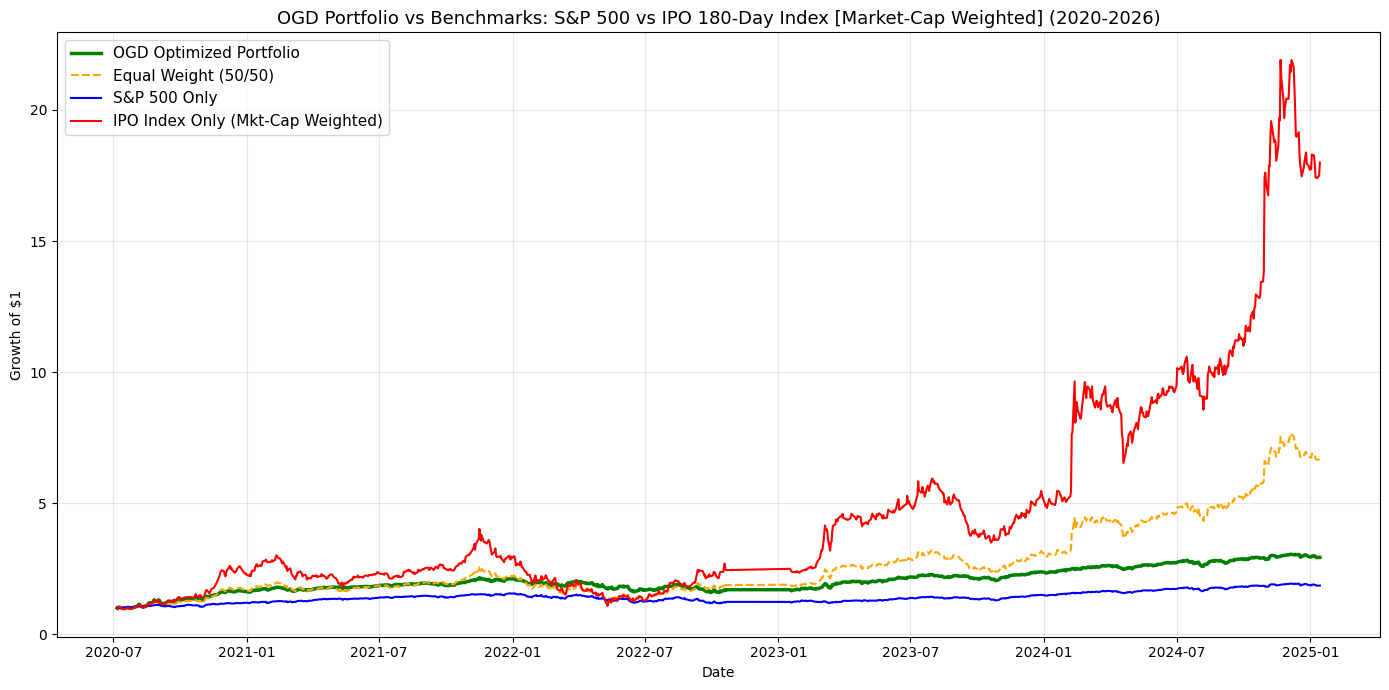

In [14]:
# Plot cumulative returns
plt.figure(figsize=(14, 7))
plt.plot(cum.index, cum["OGD_PORT"], label="OGD Optimized Portfolio", linewidth=2.5, color='green')
plt.plot(cum.index, cum["EQW"], label="Equal Weight (50/50)", linewidth=1.5, linestyle='--', color='orange')
plt.plot(cum.index, cum["SPY_Only"], label="S&P 500 Only", linewidth=1.5, color='blue')
plt.plot(cum.index, cum["IPO_Only"], label="IPO Index Only (Mkt-Cap Weighted)", linewidth=1.5, color='red')

plt.legend(loc='upper left', fontsize=11)
plt.title('OGD Portfolio vs Benchmarks: S&P 500 vs IPO 180-Day Index [Market-Cap Weighted] (2020-2026)', fontsize=13)
plt.xlabel('Date')
plt.ylabel('Growth of $1')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

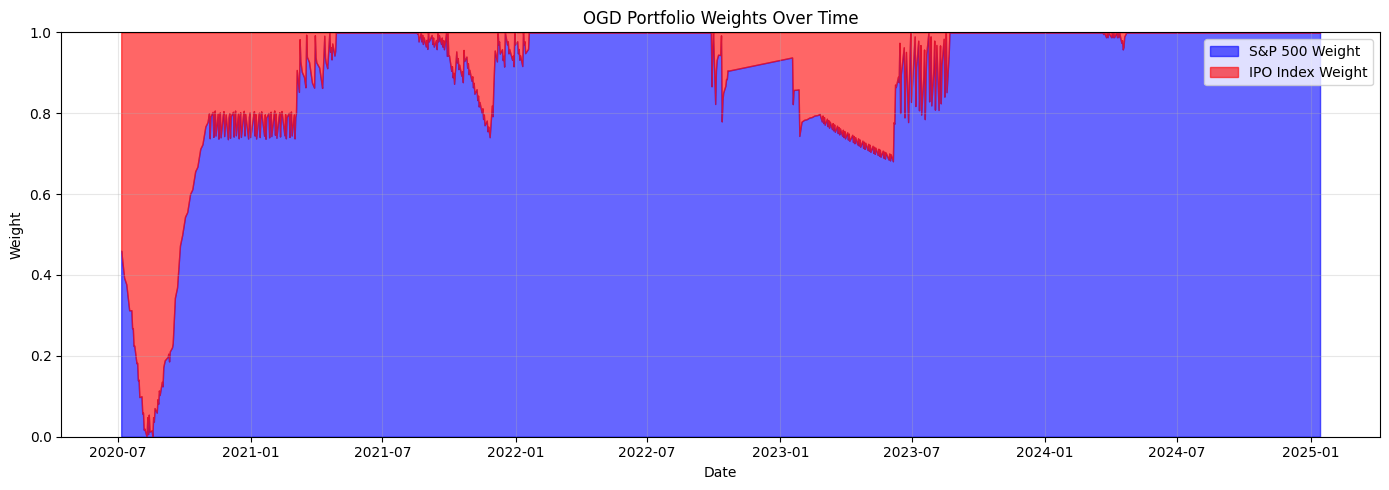

In [15]:
# Plot portfolio weights over time
plt.figure(figsize=(14, 5))
plt.fill_between(w_df.index, 0, w_df['SPY'], alpha=0.6, label='S&P 500 Weight', color='blue')
plt.fill_between(w_df.index, w_df['SPY'], 1, alpha=0.6, label='IPO Index Weight', color='red')
plt.legend(loc='upper right')
plt.title('OGD Portfolio Weights Over Time')
plt.xlabel('Date')
plt.ylabel('Weight')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

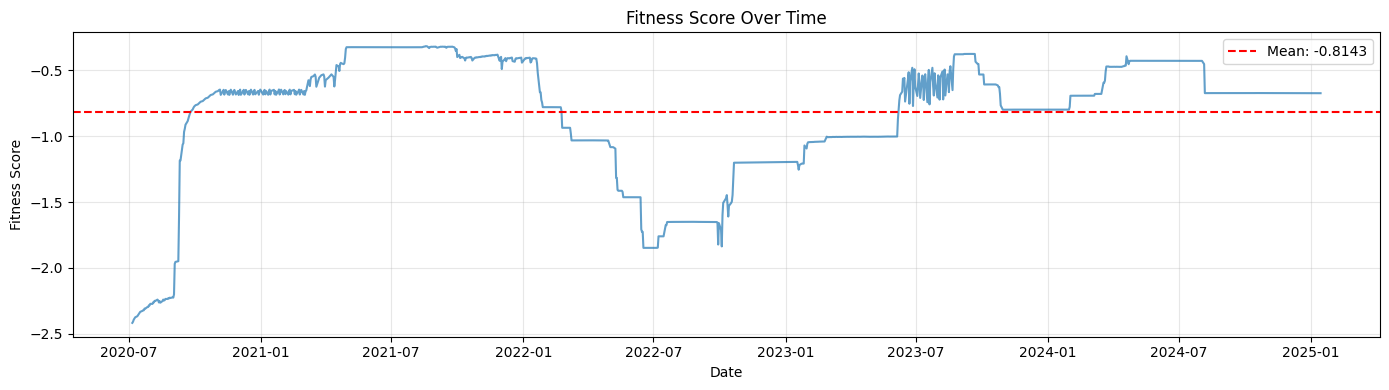

In [16]:
# Plot fitness score over time
plt.figure(figsize=(14, 4))
plt.plot(out_dates, alloc.fitness_history, alpha=0.7)
plt.axhline(y=np.mean(alloc.fitness_history), color='r', linestyle='--', label=f'Mean: {np.mean(alloc.fitness_history):.4f}')
plt.legend()
plt.title('Fitness Score Over Time')
plt.xlabel('Date')
plt.ylabel('Fitness Score')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8) Performance Metrics

In [17]:
def calculate_metrics(returns_series, name="Portfolio"):
    """Calculate key performance metrics."""
    returns = returns_series.dropna()
    
    # Annualized return
    total_return = (1 + returns).prod() - 1
    n_years = len(returns) / 252
    ann_return = (1 + total_return) ** (1/n_years) - 1
    
    # Annualized volatility
    ann_vol = returns.std() * np.sqrt(252)
    
    # Sharpe ratio (assuming 0 risk-free rate)
    sharpe = ann_return / ann_vol if ann_vol > 0 else 0
    
    # Max drawdown
    cum = (1 + returns).cumprod()
    peak = cum.cummax()
    drawdown = (cum - peak) / peak
    max_dd = drawdown.min()
    
    # Sortino ratio (downside deviation)
    downside = returns[returns < 0]
    downside_std = downside.std() * np.sqrt(252) if len(downside) > 0 else 0
    sortino = ann_return / downside_std if downside_std > 0 else 0
    
    # Calmar ratio
    calmar = ann_return / abs(max_dd) if max_dd != 0 else 0
    
    return {
        'Name': name,
        'Total Return': f"{total_return:.2%}",
        'Ann. Return': f"{ann_return:.2%}",
        'Ann. Volatility': f"{ann_vol:.2%}",
        'Sharpe Ratio': f"{sharpe:.2f}",
        'Sortino Ratio': f"{sortino:.2f}",
        'Max Drawdown': f"{max_dd:.2%}",
        'Calmar Ratio': f"{calmar:.2f}"
    }

# Calculate metrics for all strategies
metrics = []
metrics.append(calculate_metrics(port_ret, "OGD Portfolio"))
metrics.append(calculate_metrics(eqw_ret, "Equal Weight"))
metrics.append(calculate_metrics(spy_only, "S&P 500 Only"))
metrics.append(calculate_metrics(ipo_only, "IPO Index Only"))

metrics_df = pd.DataFrame(metrics).set_index('Name')
print("\n" + "="*80)
print("PERFORMANCE METRICS SUMMARY")
print("="*80)
print(metrics_df.to_string())
print("="*80)


PERFORMANCE METRICS SUMMARY
               Total Return Ann. Return Ann. Volatility Sharpe Ratio Sortino Ratio Max Drawdown Calmar Ratio
Name                                                                                                        
OGD Portfolio       193.46%      28.50%          20.06%         1.42          2.05      -26.17%         1.09
Equal Weight        577.70%      56.15%          35.03%         1.60          2.71      -51.33%         1.09
S&P 500 Only         86.12%      15.57%          16.11%         0.97          1.31      -24.50%         0.64
IPO Index Only     1699.28%      96.03%          61.36%         1.56          2.78      -73.12%         1.31


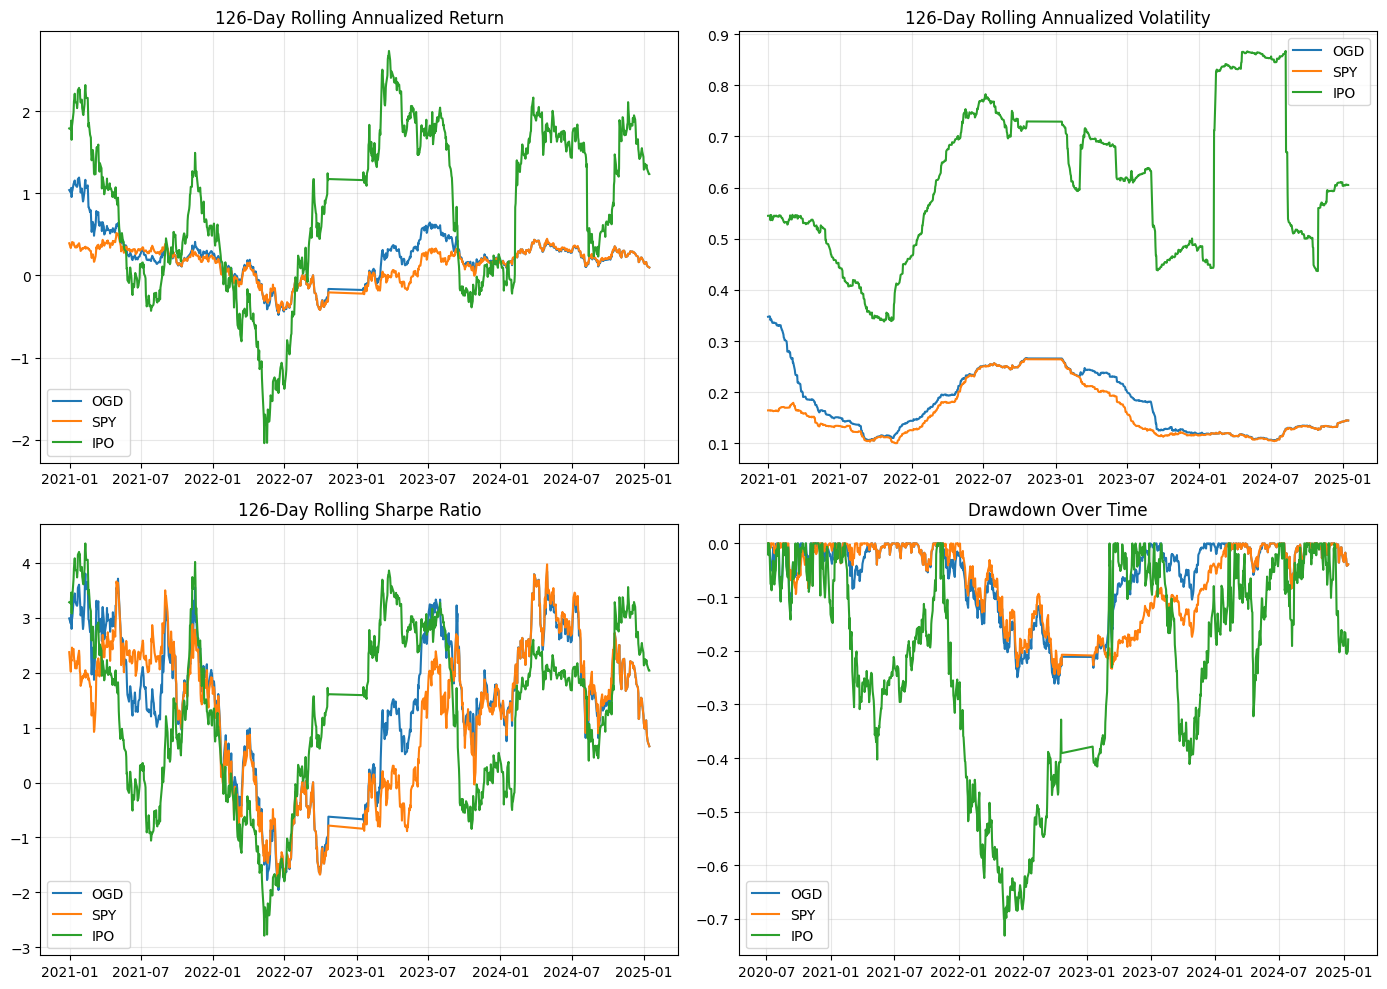

In [18]:
# Rolling metrics
rolling_window = 126  # ~6 months

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Rolling returns
ax1 = axes[0, 0]
for col, label in [(port_ret, 'OGD'), (spy_only, 'SPY'), (ipo_only, 'IPO')]:
    rolling_ret = col.rolling(rolling_window).mean() * 252
    ax1.plot(rolling_ret.index, rolling_ret, label=label)
ax1.set_title(f'{rolling_window}-Day Rolling Annualized Return')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Rolling volatility
ax2 = axes[0, 1]
for col, label in [(port_ret, 'OGD'), (spy_only, 'SPY'), (ipo_only, 'IPO')]:
    rolling_vol = col.rolling(rolling_window).std() * np.sqrt(252)
    ax2.plot(rolling_vol.index, rolling_vol, label=label)
ax2.set_title(f'{rolling_window}-Day Rolling Annualized Volatility')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Rolling Sharpe
ax3 = axes[1, 0]
for col, label in [(port_ret, 'OGD'), (spy_only, 'SPY'), (ipo_only, 'IPO')]:
    rolling_ret = col.rolling(rolling_window).mean() * 252
    rolling_vol = col.rolling(rolling_window).std() * np.sqrt(252)
    rolling_sharpe = rolling_ret / rolling_vol
    ax3.plot(rolling_sharpe.index, rolling_sharpe, label=label)
ax3.set_title(f'{rolling_window}-Day Rolling Sharpe Ratio')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Drawdown
ax4 = axes[1, 1]
for col, label in [(port_ret, 'OGD'), (spy_only, 'SPY'), (ipo_only, 'IPO')]:
    cum = (1 + col).cumprod()
    peak = cum.cummax()
    dd = (cum - peak) / peak
    ax4.plot(dd.index, dd, label=label)
ax4.set_title('Drawdown Over Time')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9) Save Results

In [19]:
# Save portfolio weights
w_df.to_csv('results/ipo_180day_mcap_weights.csv')
print("Weights saved to results/ipo_180day_mcap_weights.csv")

# Save performance summary
metrics_df.to_csv('results/ipo_180day_mcap_metrics.csv')
print("Metrics saved to results/ipo_180day_mcap_metrics.csv")

# Save combined returns for further analysis
results_df = pd.DataFrame({
    'OGD_Portfolio': port_ret,
    'Equal_Weight': eqw_ret,
    'SPY_Only': spy_only,
    'IPO_Only': ipo_only,
    'SPY_Weight': w_df['SPY'],
    'IPO_Weight': w_df['IPO_INDEX']
})
results_df.to_csv('results/ipo_180day_mcap_returns.csv')
print("Returns saved to results/ipo_180day_mcap_returns.csv")

# Save IPO index details
ipo_index_save = ipo_index.copy()
ipo_index_save['constituents'] = ipo_index_save['constituents'].apply(lambda x: ','.join(x) if x else '')
ipo_index_save.to_csv('results/ipo_180day_mcap_index.csv')
print("IPO index details saved to results/ipo_180day_mcap_index.csv")

Weights saved to results/ipo_180day_mcap_weights.csv
Metrics saved to results/ipo_180day_mcap_metrics.csv
Returns saved to results/ipo_180day_mcap_returns.csv
IPO index details saved to results/ipo_180day_mcap_index.csv


## 10) Summary

This notebook implemented:

1. **IPO 180-Day Index (Market-Cap Weighted)**: A custom index where each IPO stock stays in the basket for exactly 180 trading days after its IPO date, then exits. The index is **market-cap weighted**, meaning larger companies have proportionally higher weights (similar to how the S&P 500 is constructed).

2. **Two Asset Classes**:
   - **S&P 500** (via SPY ETF) - Large-cap US equities
   - **IPO 180-Day Index** - Market-cap weighted basket of recent IPOs

3. **Online Gradient Descent (OGD) Optimizer**: Daily rebalancing using a fitness function that maximizes:
   - Mean return
   - Minus variance penalty (risk aversion)
   - Minus max drawdown penalty
   - Minus turnover penalty

4. **Walk-Forward Backtesting**: The model only uses historical data available at each decision point (no lookahead bias).

**Key Features of Market-Cap Weighting:**
- Large IPOs (like ABNB, RIVN, COIN) have more influence on index returns
- Reduces the impact of small, potentially illiquid IPOs
- More closely mirrors how institutional investors would construct an IPO portfolio
- Natural rebalancing as market caps change daily

The optimizer dynamically shifts weights between SPY and the IPO index based on recent performance patterns, aiming to capture IPO momentum while managing downside risk through the established equity market.